# loading important libraries

In [54]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.layers as tfl
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import os

### Augmentation of the data

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import os
import glob
import cv2

# Set the directories for the original dataset and augmented dataset
original_dataset_dir = '/content/drive/MyDrive/Dataset/Dataset'
augmented_dataset_dir = '/content/drive/MyDrive/Dataset/Augmented_dataset'

# Create ImageDataGenerator object for data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

# Define the subfolders containing the banknote images
banknote_folders = ['one_jordanian_dinar', 'five_jordanian_dinar', 'ten_jordanian_dinar', 'twenty_jordanian_dinar', 'fifty_jordanian_dinar']

# Set the number of augmented images to generate for each original image
num_augmented_images = 6

# Iterate over each banknote folder
for folder in banknote_folders:
    # Create subdirectory for augmented images in the current banknote folder
    augmented_folder = os.path.join(augmented_dataset_dir, folder)
    os.makedirs(augmented_folder, exist_ok=True)

    # Set the directory for the current banknote folder in the original dataset
    current_folder = os.path.join(original_dataset_dir, folder)

    # Iterate over each image in the current banknote folder
    image_files = glob.glob(os.path.join(current_folder, '*.jpg'))
    for image_file in image_files:
        # Load the image
        img = cv2.imread(image_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.reshape((1,) + img.shape)

        # Generate augmented images and save them to the augmented folder
        i = 0
        for batch in datagen.flow(img, batch_size=1, save_to_dir=augmented_folder, save_prefix='augmented_', save_format='jpg'):
            i += 1
            if i >= num_augmented_images:
                break


In [ ]:
# import rarfile

# rar_file_path = "/content/drive/MyDrive/Dataset.rar"

# # Create a RarFile object
# rf = rarfile.RarFile(rar_file_path)

# # Extract all files to a directory
# rf.extractall("/content/drive/MyDrive/Dataset")


### Train_Test_Validation split

In [ ]:
import os
import random
import shutil

root_directory = '/content/drive/MyDrive/Dataset/Final_dataset'
dataset_directory = '/content/drive/MyDrive/Dataset/Augmented_dataset'

# Create train, test, and validation directories
train_directory = os.path.join(root_directory, 'train')
test_directory = os.path.join(root_directory, 'test')
validation_directory = os.path.join(root_directory, 'validation')

os.makedirs(train_directory)
os.makedirs(test_directory)
os.makedirs(validation_directory)

labels = ["fifty_jordanian_dinar", "five_jordanian_dinar", "ten_jordanian_dinar", "twenty_jordanian_dinar", "one_jordanian_dinar"]

# Iterate over the labels
for label in labels:
    # Create subdirectories for the label in train, test, and validation sets
    train_label_directory = os.path.join(train_directory, label)
    test_label_directory = os.path.join(test_directory, label)
    validation_label_directory = os.path.join(validation_directory, label)

    os.makedirs(train_label_directory)
    os.makedirs(test_label_directory)
    os.makedirs(validation_label_directory)

    # Get the list of images for the label
    label_directory = os.path.join(dataset_directory, label)
    images = os.listdir(label_directory)
    random.shuffle(images)

    # Split the images into train, test, and validation sets
    train_images = images[:int(0.8 * len(images))]  # 80% for training
    test_images = images[int(0.8 * len(images)):int(0.9 * len(images))]  # 10% for testing
    validation_images = images[int(0.9 * len(images)):]  # 10% for validation

    # Move or copy the images to the respective directories
    for image in train_images:
        shutil.copy(os.path.join(label_directory, image), os.path.join(train_label_directory, image))
    for image in test_images:
        shutil.copy(os.path.join(label_directory, image), os.path.join(test_label_directory, image))
    for image in validation_images:
        shutil.copy(os.path.join(label_directory, image), os.path.join(validation_label_directory, image))


# Model archeticture and compilation

In [55]:
from keras.api._v2.keras import activations

input_shape = (224, 224, 3)

model = tf.keras.Sequential([
    tfl.Conv2D(filters=64, kernel_size=(4,4), strides=(1, 1), 
               padding='same', input_shape=input_shape, activation='relu'),
    tfl.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same'),

    
    tfl.Conv2D(filters=32, kernel_size=(2, 2), strides=(1, 1), padding='same'),
    tfl.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    tfl.BatchNormalization(),
    
    tfl.Conv2D(filters=16, kernel_size=(2, 2), strides=(1, 1), padding='same', activation='relu'),
    tfl.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    tfl.BatchNormalization(),
    tfl.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), 
               padding='same', input_shape=input_shape, activation='relu'),
    tfl.MaxPool2D(pool_size=(2,2), strides=(2, 2), padding='same'),
    tfl.BatchNormalization(),

    tfl.Flatten(),
    tfl.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tfl.Dropout(0.1),  # Adding a dropout layer with a dropout rate of 0.5
    
    tfl.Dense(5, activation='softmax')
])


In [69]:
# Define the optimizer with a custom learning rate
learning_rate = 0.0001  # Replace with your chosen learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Compile the model with the optimizer


model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 224, 224, 64)      3136      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 112, 112, 32)      8224      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_11 (Bat  (None, 56, 56, 32)       128       
 chNormalization)                                                
                                                      

In [70]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [71]:
from keras.preprocessing.image import ImageDataGenerator

# Set the directory for the pre-augmented training, validation, and test data
train_directory = 'Final_dataset/train'
validation_directory = 'Final_dataset/validation'
test_directory = 'Final_dataset/test'

# Set the input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 5

# Set the batch size
batch_size = 32

# Create ImageDataGenerator object for rescaling
datagen = ImageDataGenerator(rescale=1./255)

# Create the train, validation, and test data generators
train_generator = datagen.flow_from_directory(
    directory=train_directory,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    directory=validation_directory,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = datagen.flow_from_directory(
    directory=test_directory,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)




Found 19022 images belonging to 5 classes.
Found 2380 images belonging to 5 classes.
Found 2378 images belonging to 5 classes.


##preparing callbacks for the model 

In [72]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

# Define the callbacks
checkpoint = ModelCheckpoint('model_weights.h5', save_best_only=True)
early_stopping = EarlyStopping(patience=3, monitor='accuracy')
tensorboard = TensorBoard(log_dir='logs')

##Training

In [73]:
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(factor=1e-3,verbose=True)

# Now you can use `train_generator`, `val_generator`, and `test_generator` as input data for model.fit()
# The recommended number of steps per epoch is number of trianing examples/Batch size
history = model.fit(train_generator, steps_per_epoch=400, epochs=15
                    , validation_data=val_generator, validation_steps=16, callbacks=[checkpoint,tensorboard,lr_schedule])


Epoch 1/15
400/400 [==============================] - 58s 138ms/step - loss: 0.1465 - accuracy: 0.9847 - precision_7: 0.9880 - recall_7: 0.9820 - auc_7: 0.9995 - val_loss: 0.1148 - val_accuracy: 0.9902 - val_precision_7: 0.9941 - val_recall_7: 0.9844 - val_auc_7: 0.9999 - lr: 1.0000e-04
Epoch 2/15
400/400 [==============================] - 57s 141ms/step - loss: 0.1074 - accuracy: 0.9899 - precision_7: 0.9921 - recall_7: 0.9869 - auc_7: 0.9998 - val_loss: 0.0982 - val_accuracy: 0.9902 - val_precision_7: 0.9961 - val_recall_7: 0.9883 - val_auc_7: 0.9999 - lr: 1.0000e-04
Epoch 3/15
400/400 [==============================] - 55s 137ms/step - loss: 0.0905 - accuracy: 0.9912 - precision_7: 0.9938 - recall_7: 0.9895 - auc_7: 0.9997 - val_loss: 0.0804 - val_accuracy: 0.9941 - val_precision_7: 0.9980 - val_recall_7: 0.9922 - val_auc_7: 0.9999 - lr: 1.0000e-04
Epoch 4/15
400/400 [==============================] - 54s 134ms/step - loss: 0.0833 - accuracy: 0.9896 - precision_7: 0.9920 - recall_7:

In [75]:
# Evaluate the model on the test data
model.evaluate(test_generator)

75/75 [==============================] - 11s 148ms/step - loss: 0.0588 - accuracy: 0.9899 - precision_7: 0.9911 - recall_7: 0.9882 - auc_7: 0.9994


[0.05880102142691612,
 0.9899075031280518,
 0.991142988204956,
 0.9882254004478455,
 0.9994171261787415]

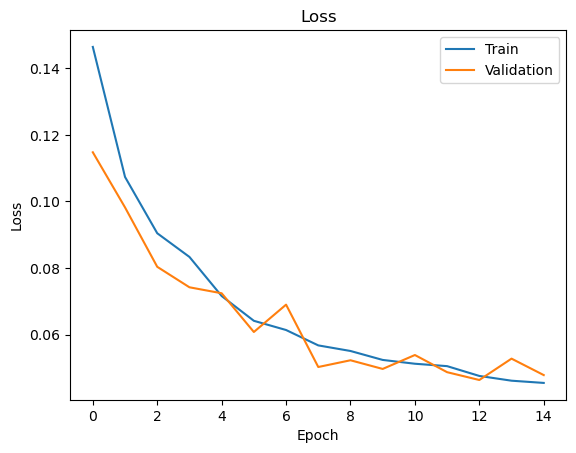

In [76]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

# Other visualizations can be added similarly


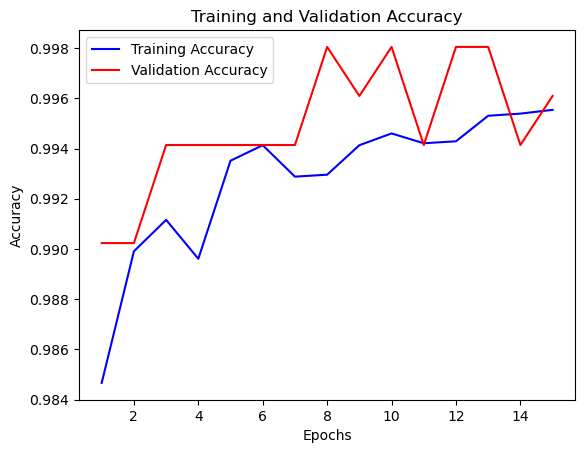

In [77]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot the accuracy
epochs = range(1, len(train_acc) + 1)
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [78]:
model.save('final_model2.h5',save_format='h5')

In [79]:
model.save_weights('final_weights2.h5')

Preprocess function

In [80]:
def preprocess(frame):
    # Resize the frame to the desired input size
    resized_frame = cv2.resize(frame, (224, 224))  # Adjust the size according to your model's input shape

    # Normalize pixel values if required by your model
    normalized_frame = resized_frame / 255.0  # Normalize to [0, 1] range

    return normalized_frame


In [82]:
def get_banknote_denomination(class_id):
    denominations = {
        0: "$1",
        1: "$5",
        2: "$10",
        3: "$20",
        4: "$50"
    }
    return denominations.get(class_id, "Unknown Banknote")


In [85]:
import cv2
import numpy as np
import tensorflow as tf

# Load your pre-trained model
model = tf.keras.models.load_model('final_model/final_model2.h5')

# Initialize the video capture from webcam
video_capture = cv2.VideoCapture(0)

while True:
    # Read a frame from the video capture
    ret, frame = video_capture.read()

    # Preprocess the frame for model input
    preprocessed_frame = preprocess(frame)  # Implement your preprocessing function

    # Expand dimensions to match the model's input shape
    preprocessed_frame = np.expand_dims(preprocessed_frame, axis=0)

    # Perform inference on the preprocessed frame
    predictions = model.predict(preprocessed_frame)

    # Process the predictions
    predicted_class_id = np.argmax(predictions)
    banknote_denomination = get_banknote_denomination(predicted_class_id)  # Implement the function to get denomination

    # Display the result on the frame
    cv2.putText(frame, f"Detected banknote: {banknote_denomination}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
    cv2.imshow('Video', frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and close windows
video_capture.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 32ms/step
